# TensorFlow Tutorial 01
## Simple Linear Model

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

C:\Users\AFGHAN92\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## One-Hot Encoding

In [4]:
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [6]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

## Data dimensions

In [7]:
# We know the MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits
num_classes = 10

## Helper-function for plotting images

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # assert - if above the condition will not be met program will throw an exception
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Enumerate returns index and value from array
        # Plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted class
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])        

## Plot a few images to see if data is correct

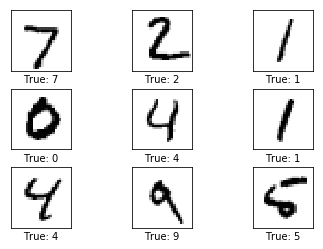

In [9]:
# Get the first 10 images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

## Placeholder variables

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables to be optimized

In [11]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [12]:
biases = tf.Variable(tf.zeros([num_classes]))

## Model

In [13]:
logits = tf.matmul(x, weights) + biases

In [14]:
y_pred = tf.nn.softmax(logits)

In [15]:
y_pred_cls = tf.argmax(y_pred, axis=1)

## Cost-function to be optimized

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

In [17]:
cost = tf.reduce_mean(cross_entropy)

## Optimization method

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## Performance measures

In [19]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [20]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [21]:
# Create TensorFlow session
session = tf.Session()

In [22]:
# Initialize variables
session.run(tf.global_variables_initializer())

In [23]:
# Helper-function to perform optimization iterations
batch_size = 100

def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of trainiong examples.
        # x_batch naw holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict ith the proper names
        # for placecholder variables in the TensorFlow graph
        # Note that the placecholder for y_true_cls is not set
        # becouse it is not used during training
        feed_dict_train  = {x: x_batch,
                           y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict=feed_dict_train)

In [24]:
# Helper-functions to show performance
feed_dict_test = {x: data.test.images,
                 y_true: data.test.labels,
                 y_true_cls: data.test.cls}

In [25]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [26]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [27]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [28]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Performance before any optimization

In [29]:
print_accuracy()

Accuracy on test-set: 9.8%


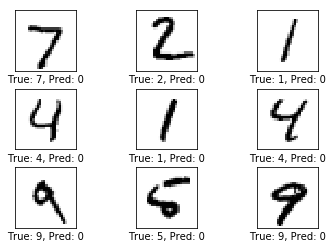

In [30]:
plot_example_errors()

## Performance after 1 optimization iteration

In [31]:
optimize(num_iterations=1)

In [32]:
print_accuracy()

Accuracy on test-set: 26.6%


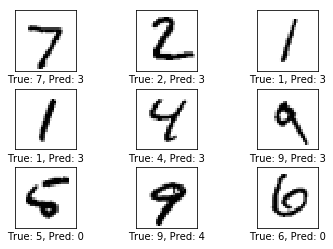

In [33]:
plot_example_errors()

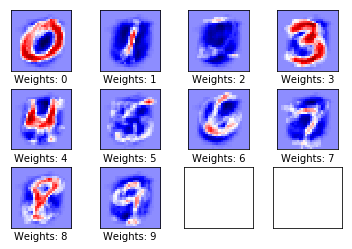

In [34]:
plot_weights()

## Performance after 10 optimization iteration

In [35]:
optimize(num_iterations=9)

In [36]:
print_accuracy()

Accuracy on test-set: 73.6%


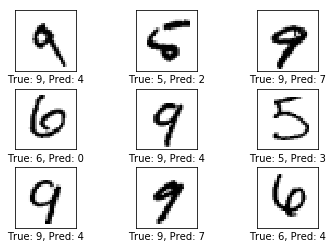

In [37]:
plot_example_errors()

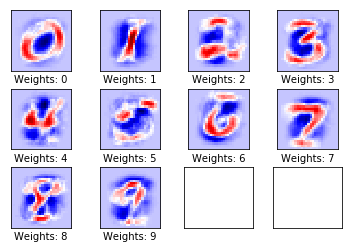

In [38]:
plot_weights()

## Performance after 1000 optimization iteration

In [39]:
optimize(num_iterations=990)

In [40]:
print_accuracy()

Accuracy on test-set: 91.9%


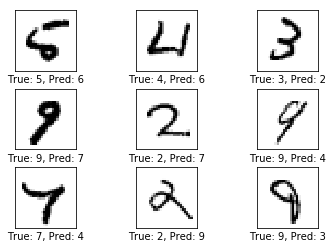

In [41]:
plot_example_errors()

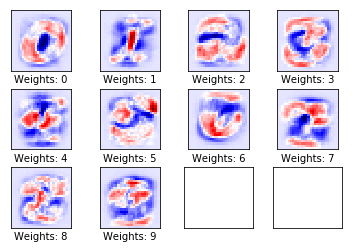

In [42]:
plot_weights()

[[ 962    0    1    1    0    3   10    1    2    0]
 [   0 1108    2    2    0    2    4    2   15    0]
 [  12   10  904   10   10    5   14   15   45    7]
 [   4    1   20  900    0   37    5   14   23    6]
 [   1    2    3    1  911    2   14    2   10   36]
 [  10    3    1   25    6  783   23    6   29    6]
 [  11    3    4    1   10    8  918    1    2    0]
 [   3    8   20    7    7    1    0  948    2   32]
 [  10    4    6   18    9   37   13   11  861    5]
 [  13    7    1   11   37    9    0   31    7  893]]


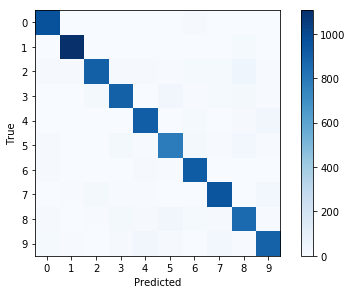

In [43]:
 print_confusion_matrix()